## generate a few simple NN models

In [1106]:
# import stuff
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fft import fft,fftfreq
import datetime
import scipy

In [284]:
# define a simple network composed of recurrent J weights and a single linear readout
class simpleRNN(nn.Module):
    def __init__(self, nneurons: int = 200, save_path: str = None, lr: float =1e-3,
                 device: torch.device = None, dt: float=0.01, tau: float = 0.1):
        super().__init__()

        # will almost always want to use the CPU to train
        if device is None:
            self.device = torch.device('cpu')
            device = self.device
        else:
            self.device = device

        # initialize all of our weights and set a few parameters
        J_mat = (1.2 * np.random.randn(nneurons, nneurons)/np.sqrt(nneurons))
        self.J = nn.Parameter(torch.from_numpy(J_mat.astype(np.float32)).to(device))
        self.Wout = nn.Parameter(torch.from_numpy((np.random.randn(1, nneurons)/np.sqrt(nneurons)).astype(np.float32)).to(device))
        self.neural_nonlinearity = nn.Tanh()
        self.dt = dt
        self.tau = tau
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = save_path
        self.total_time = 5
        self.Loss = []
        self.create_targets()
        self.output = None
        self.batch_size = 1
        self.initialState = torch.randn((self.J.shape[0], self.batch_size), device=device) / np.sqrt(self.J.shape[0])

    def create_targets(self, frequency: float = 1, amplitude: int = 1):

        times = np.arange(0,self.total_time,self.dt)
        targets = amplitude * np.sin(times * (frequency * (2*np.pi)))
        self.Targets = targets

    def forward(self, targets: np.ndarray = None, noise_scale: float = 1e-5):
        device = self.device
        batch_size = 1
        Targets = torch.from_numpy(targets.astype(np.float32))
        position_store = torch.zeros(int(self.total_time/self.dt), batch_size)
        xm1 = self.initialState
        rm1 = self.neural_nonlinearity(xm1)

        for idx,ti in enumerate(np.arange(0,self.total_time,self.dt)):
            xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 +
                                        torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
            rm1 = self.neural_nonlinearity(xm1)
            position_store[idx] = self.Wout @ rm1
        loss = ((Targets - position_store[:,0])**2).mean(axis=0).mean()

        self.output = position_store
        return loss


    def fit_initial_m1(self, trials: int = 1000):
        m1_params = [self.J, self.Wout]
        optimizer = torch.optim.Adam(m1_params, lr=1e-3)
        for trial in range(trials):
            optimizer.zero_grad()
            targets = self.Targets
            loss = self.forward(targets)
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()

    # return rates (without any noise)
    def returnRates(self):
        xm1 = self.initialState
        rm1 = self.neural_nonlinearity(xm1)
        rates = np.zeros((int(self.total_time/self.dt),int(xm1.shape[0])))

        for idx,ti in enumerate(np.arange(0,self.total_time,self.dt)):
            xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1))
            rm1 = self.neural_nonlinearity(xm1)
            rates[idx,:]=rm1.detach().numpy()[:,0]

        return rates






### Train the model with backprop

In [285]:
# initialize and fit the model
model = simpleRNN()
model.fit_initial_m1()

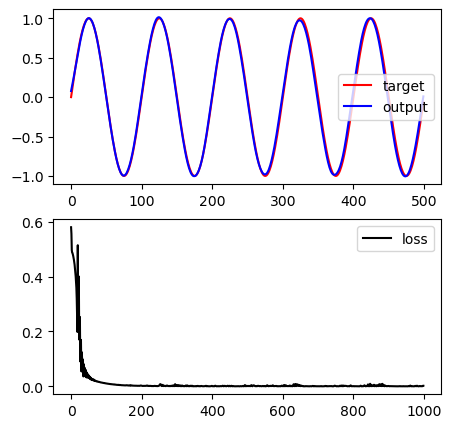

In [286]:
# plot the final output and the loss over training
modelOutput = model.output.detach().numpy()
target = model.Targets
loss = model.Loss
plt.figure(figsize=(5,5))
plt.subplot(2,1,1);
plt.plot(target,'r',label = 'target');
plt.plot(modelOutput,'b',label='output');
plt.legend();
plt.subplot(2,1,2);
plt.plot(loss,'k',label='loss');
plt.legend();

# return the rates
rates = model.returnRates()

# get some useful numbers
trlDur,numN = rates.shape


four dimensions explain 0.9679188012240711 percent of total variance


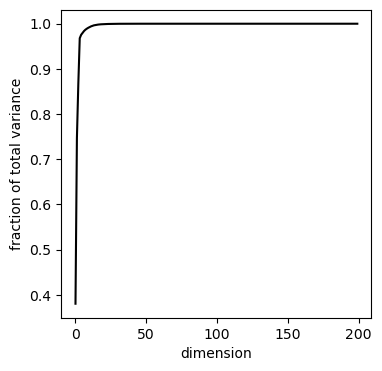

In [287]:
# run pca on the rates and extract the top K factors
pca = PCA(n_components=numN)
proj = pca.fit_transform(rates)

# generate a scree plot
varExp = pca.explained_variance_ratio_
plt.figure(figsize=(4,4))
plt.plot(np.cumsum(varExp),'k')
plt.ylabel('fraction of total variance');
plt.xlabel('dimension');

# how much variance do we explain with 4 dimensions?
print('four dimensions explain ' + str(np.sum(varExp[:4])) + ' percent of total variance');

### Train a second model to generate Z

In [949]:
### Train W weights using RLS ###


## define a few parameters ##

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
numZ = 4


## draw our U and J0 weights ##

# U first
U = np.random.uniform(low=uMin,high=uMax, size=(numZ,numN)) * g_U

# J0
J0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))


## define our target latents, Z ##
Z_target = proj[:,:numZ]

## number of trials to train ##
numTrials = 10

## trial duration ##
trlDur = 500

## initialize W ##
W = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ))

## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))

## initial latents, z0 ##
z0 = np.zeros((numZ,1))

## initial value of P ##
P = np.eye(numN) / alpha


In [952]:
# cycle through trials

# initialize an array to hold output
networkOutput = np.zeros((trlDur,numZ,numTrials))
for trl in range(numTrials):

    # set the initial state, rate, and latent
    x = np.copy(x0)
    r = np.copy(r0)
    z = np.copy(z0)

    # cycle through the trial
    for ii in range(trlDur):

        # update our state
        x += (1/tau) * (-x + (J0.T@r) + (U.T@z))

        # calculate our current rate
        r = np.tanh(x)

        # calculate the current z
        z = W.T@r

        # save the output
        networkOutput[ii,:,trl] = z[:,0]

        # calculate the error
        error = np.atleast_2d(z[:,0] - Z_target[ii,:])

        # update the weights
        W = W - ((P @ r)@error)

        # update P
        P = P - ((P @ r @ r.T @ P)/(1 + (r.T @ P @ r)))


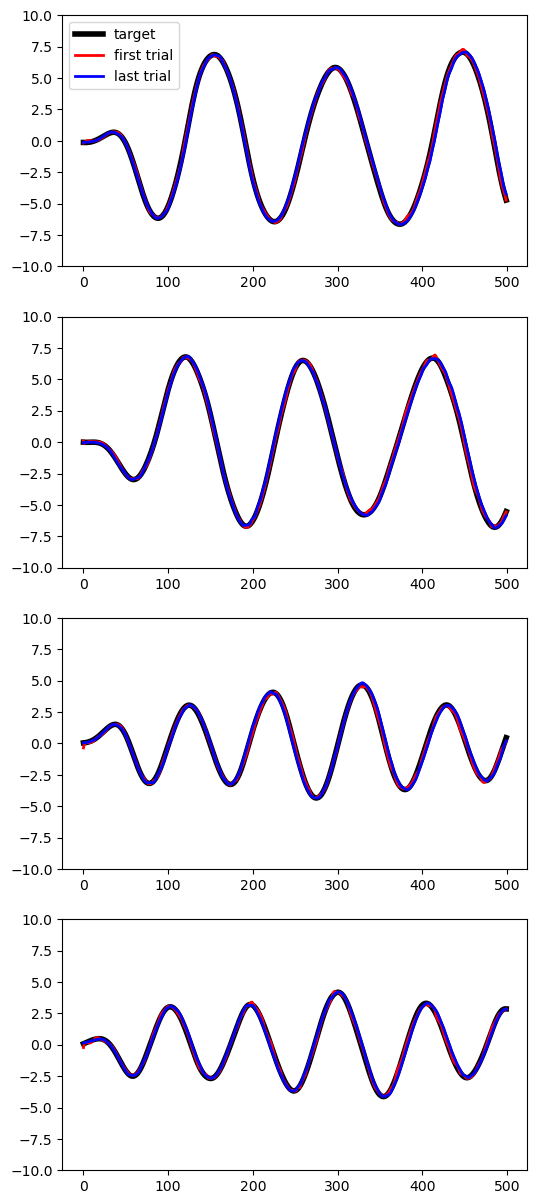

In [953]:
# plot the first and last trial (along with the target)
plt.figure(figsize = (6,15))

for ii in range(4):
    plt.subplot(4,1,ii+1);

    # plot the target
    plt.plot(Z_target[:,ii],'k',linewidth=4,label='target');

    # plot the first trial
    plt.plot(networkOutput[:,ii,0],'r',linewidth=2,label='first trial')

    # plot the last trial
    plt.plot(networkOutput[:,ii,-1],'b',linewidth=2,label='last trial')

    # change the y scale
    plt.ylim([-10,10]);

    if ii==0:
        plt.legend()


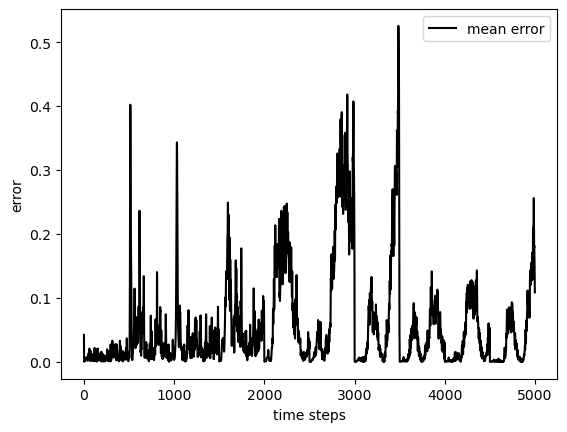

In [753]:
# plot error (averaged over output dimensions) as a function of training steps
meanError = ((networkOutput - np.tile(Z_target[:,:,np.newaxis], (1,1,numTrials)))**2).mean(axis=1).squeeze()

# reshape to be size (T x Trl) x 1
meanError_rs = np.reshape(meanError,(-1,1),order='F')

# plot
plt.plot(meanError_rs[:,0],'k',label='mean error');
plt.legend();
plt.xlabel('time steps');
plt.ylabel('error');

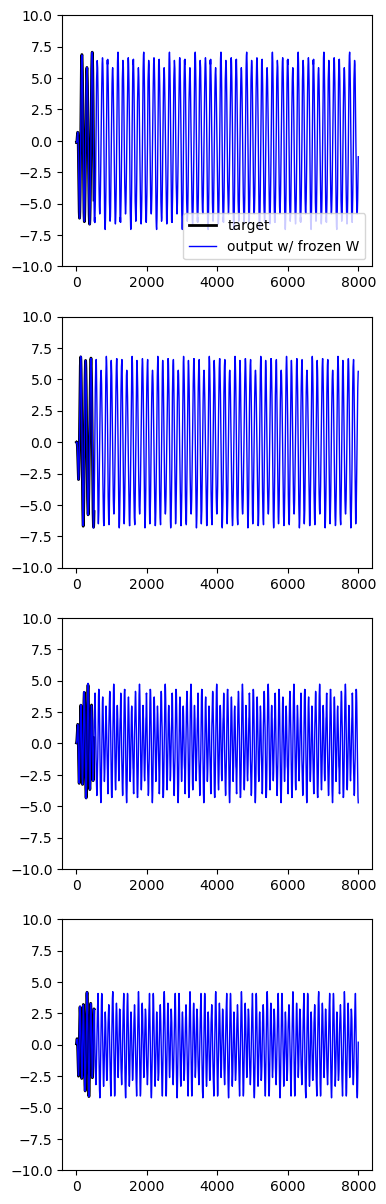

In [954]:
# freeze the weights, then run forward

# set the initial state, rate, and latent
x = np.copy(x0)
r = np.copy(r0)
z = np.copy(z0)

# increase trial duration
trlDur = 8000

# initialze a vector to save output
modelOutput_frozenW = np.zeros((trlDur,numZ))

# cycle through the trial
for ii in range(trlDur):

    # update our state
    x += (1/tau) * (-x + (J0.T@r) + (U.T@z))

    # calculate our current rate
    r = np.tanh(x)

    # calculate the current z
    z = W.T@r

    # save the output
    modelOutput_frozenW[ii,:] = z[:,0]

# plot output
plt.figure(figsize = (4,15))

for ii in range(4):
    plt.subplot(4,1,ii+1);

    # plot the target
    plt.plot(Z_target[:,ii],'k',linewidth=2,label='target');

    # plot output
    plt.plot(modelOutput_frozenW[:,ii],'b',linewidth=1,label='output w/ frozen W')

    # change the y scale
    plt.ylim([-10,10]);

    if ii==0:
        plt.legend()


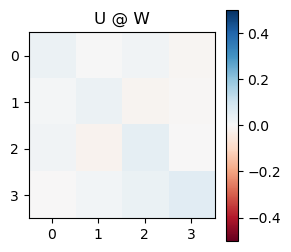

In [755]:
##  how orthogonal are U and W? ##

# normalize columns of W and (rows of) U to unity
W_norm = W / np.linalg.norm(W,axis=0)
U_norm = (U.T / np.linalg.norm(U.T,axis=0)).T

# calculate product of U and W
plt.figure(figsize=(3,3))
plt.imshow(U_norm@W_norm,cmap='RdBu',vmin=-0.5,vmax=0.5);plt.colorbar();
plt.title('U @ W');


In [756]:
# define a new U (U_pert) that is just U plus some noise. What effect does this perturbation have on X?

# magnitude of change for U
pertMag = 0.01

# define U_pert
U_pert = U + np.random.normal(loc=0,scale=pertMag,size=U.shape)

In [757]:
# run the network forward

# keep track of Z
Z_pert = np.zeros((trlDur,numZ))

# set the inital states/rates/Z
x = np.copy(x0)
r = np.copy(r0)
z = np.copy(z0)

# cycle through time
for ii in range(trlDur):

    # update our state
    x += (1/tau) * (-x + (J0.T@r) + (U_pert.T@z))

    # calculate our current rate
    r = np.tanh(x)

    # calculate the current z
    z = W.T@r

    # save the output
    Z_pert[ii,:] = z[:,0]

In [758]:
# get a copy of the Z's from the unperturbed network

# keep track of Z
Z_noPerturb = np.zeros((trlDur,numZ))

# set the inital states/rates/Z
x = np.copy(x0)
r = np.copy(r0)
z = np.copy(z0)

# cycle through time
for ii in range(trlDur):

    # update our state
    x += (1/tau) * (-x + (J0.T@r) + (U.T@z))

    # calculate our current rate
    r = np.tanh(x)

    # calculate the current z
    z = W.T@r

    # save the output
    Z_noPerturb[ii,:] = z[:,0]

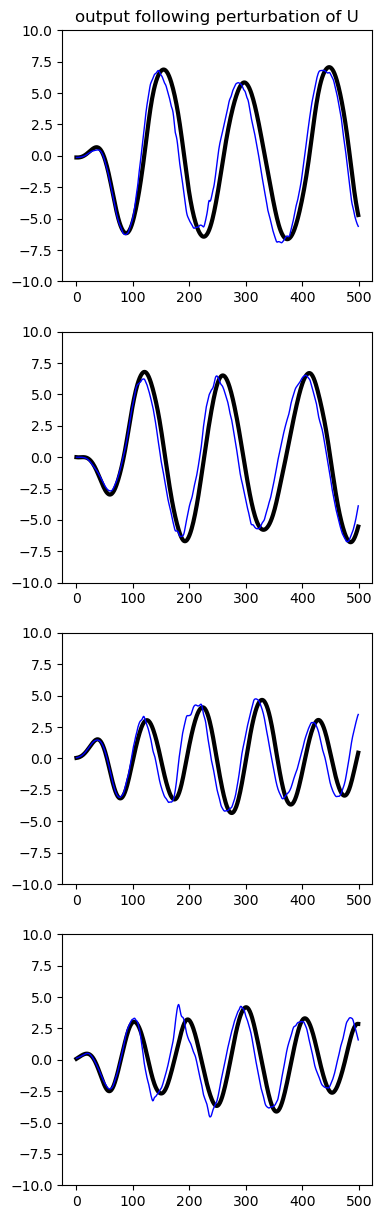

In [766]:
# plot the target Z and perturbed Z
plt.figure(figsize = (4,15))

for ii in range(4):
    plt.subplot(4,1,ii+1);

    # plot the target
    plt.plot(Z_target[:plotL,ii],'k',linewidth=3,label='target');

    # plot the output
    plt.plot(Z_pert[:plotL,ii],'b',linewidth=1,label='Z')

    # change the y scale
    plt.ylim([-10,10]);

    if ii==0:
        plt.title('output following perturbation of U');


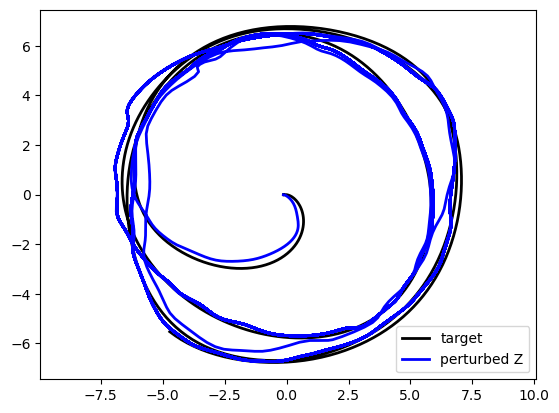

In [767]:
# plot first 2 PCs of the target and perturbed Z
# plot target
plt.plot(Z_target[:,0],Z_target[:,1],'k',linewidth=2,label='target');
plt.plot(Z_pert[:,0],Z_pert[:,1],'b',linewidth=2,label='perturbed Z');
plt.xlim([-12,12]);
plt.ylim([-12,12]);
plt.axis('equal');
plt.legend();

In [795]:
# function for returning peak frequency of a 1d Trace
def returnPeakFreq(signal, sampling_interval):

    # length of window
    L = signal.size

    # calculate frequency distribution
    freqDist = np.abs(fft(signal)[:L//2])

    # find where the peak occurs
    peakIdx = np.argmax(freqDist)

    # calculate the bins of the distribution
    freqBins = fftfreq(L,sampling_interval)[:L//2]

    # return the peak bin
    return freqBins[peakIdx]

# function for returning the MSE between two traces, after one has been stretched to match the other.
def calculateAdjustedMSE(signal1, signal2, freq1, freq2):

    # duration of original signal
    oSignalDur = signal1.size

    # figure out which signal needs to be stretched
    if freq1 < freq2:
        slowSignal = signal1
        fastSignal = signal2
        slowFreq = freq1
        fastFreq = freq2
        stretchFlag = True
    elif freq2 < freq1:
        slowSignal = signal2
        fastSignal = signal1
        slowFreq = freq2
        fastFreq = freq1
        stretchFlag = True
    else:
        # if both signals have the same dominant frequency, no need to do any stretching
        slowSignal = signal1
        fastSignal = signal2
        stretchFlag = False

    if stretchFlag:

        # calculate the ratio of the fast signal to the slow signal
        freqRatio = fastFreq/slowFreq

        # generate a stretched time base for the faster signal
        fastTimes_stretched = np.arange(0,oSignalDur) * freqRatio

        # interpolate the faster signal to get a signal the same length as the slow signal
        fastSignal = np.interp(np.arange(0,oSignalDur),fastTimes_stretched,fastSignal)

    # now calculate the MSE
    return ((slowSignal - fastSignal)**2).mean()

# function for running network forward with a given U_pert
def runWithUPert(uPert):

    # run the network forward

    # keep track of Z
    Z_pert = np.zeros((trlDur,numZ))

    # set the inital states/rates/Z
    x = np.copy(x0)
    r = np.copy(r0)
    z = np.copy(z0)

    # cycle through time
    for ii in range(trlDur):

        # update our state
        x += (1/tau) * (-x + (J0.T@r) + (uPert.T@z))

        # calculate our current rate
        r = np.tanh(x)

        # calculate the current z
        z = W.T@r

        # save the output
        Z_pert[ii,:] = z[:,0]

    # return output
    return Z_pert

In [796]:
# generate a bunch of random U_perts, calculate change in frequency in each dimension

# number of different perturbations
numPerts = 500

# initialize an array to hold change in frequencies (numPerts x numZ)
dFreq = np.zeros((numPerts,numZ)) + np.nan

# MSE for each perturbation and each Z
MSE = np.zeros((numPerts,numZ)) + np.nan

# save each U_pert
U_pert_all = np.zeros((U.shape[0],U.shape[1],numPerts))

# save a bit of time by calculating the dominant frequency for each of the unperturbed Z's
Z_freq = np.zeros(numZ) + np.nan
for ii in range(numZ):
    Z_freq[ii] = returnPeakFreq(Z_noPerturb[:,ii], dt)

# cycle through perturbations
for ii in range(numPerts):

    # generate our perturbation
    U_pert = U + np.random.normal(loc=0,scale=pertMag,size=U.shape)

    # save the perturbation
    U_pert_all[:,:,ii] = np.copy(U_pert)

    # get the output for this perturbation
    out = runWithUPert(U_pert)

    # for each dimension, calculate change in frequency and adjusted MSE
    for jj in range(numZ):

        # pull out our original output and perturbed output for this dimension
        output_noPerturb = Z_noPerturb[:,jj]
        output_perturb = out[:,jj]

        # calculate the dominant frequency in the perturbed Z
        perturbFreq = returnPeakFreq(output_perturb, dt)

        # save the change in the frequency
        dFreq[ii,jj] = perturbFreq - Z_freq[jj]

        # calculate the adjusted MSE
        MSE[ii,jj] = calculateAdjustedMSE(output_perturb, output_noPerturb, perturbFreq, Z_freq[jj])


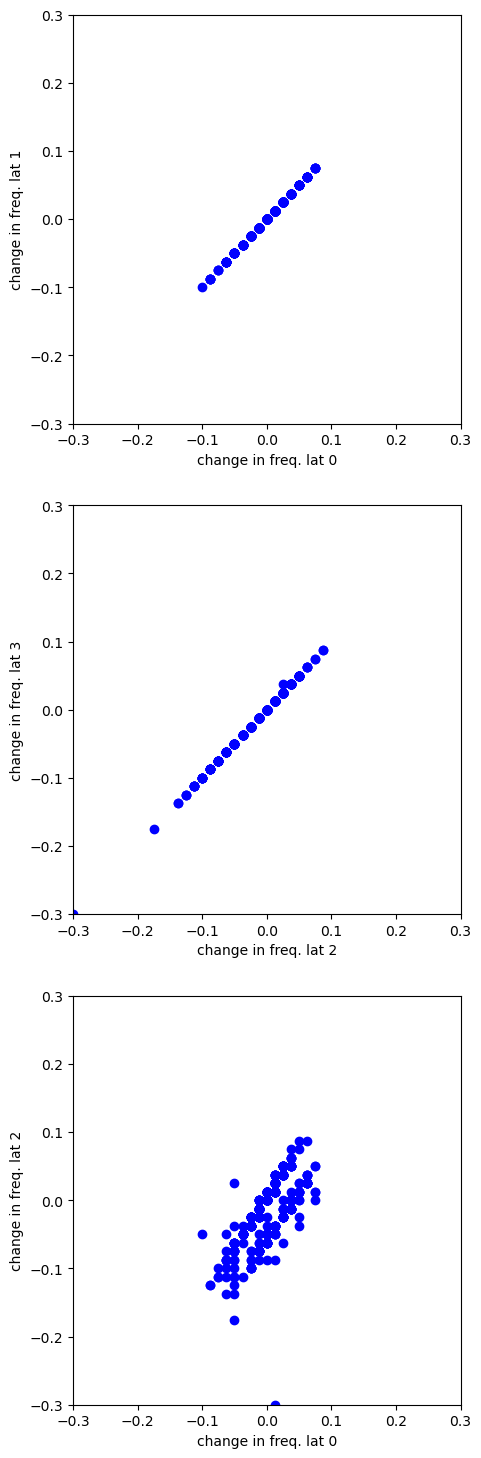

In [797]:
# plot the changes in frequency
limits = [-0.3,0.3]

plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
plt.plot(dFreq[:,0],dFreq[:,1],'bo');
plt.xlabel('change in freq. lat 0');
plt.ylabel('change in freq. lat 1');
plt.xlim(limits);
plt.ylim(limits);

plt.subplot(3,1,2)
plt.plot(dFreq[:,2],dFreq[:,3],'bo');
plt.xlabel('change in freq. lat 2');
plt.ylabel('change in freq. lat 3');

plt.xlim(limits);
plt.ylim(limits);
plt.subplots_adjust(top=1.5);

plt.subplot(3,1,3)
plt.plot(dFreq[:,0],dFreq[:,2],'bo');
plt.xlabel('change in freq. lat 0');
plt.ylabel('change in freq. lat 2');

plt.xlim(limits);
plt.ylim(limits);
plt.subplots_adjust(top=1.5);


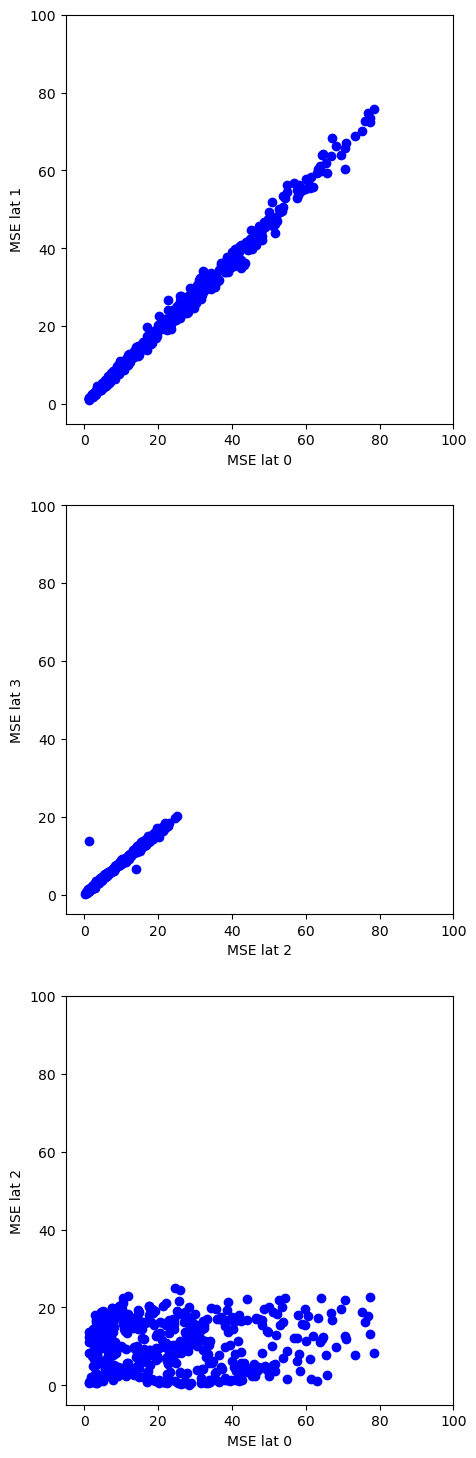

In [798]:
# plot the MSE in each dimension
limits = [-5,100]

plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
plt.plot(MSE[:,0],MSE[:,1],'bo');
plt.xlabel('MSE lat 0');
plt.ylabel('MSE lat 1');
plt.xlim(limits);
plt.ylim(limits);

plt.subplot(3,1,2)
plt.plot(MSE[:,2],MSE[:,3],'bo');
plt.xlabel('MSE lat 2');
plt.ylabel('MSE lat 3');

plt.xlim(limits);
plt.ylim(limits);
plt.subplots_adjust(top=1.5);

plt.subplot(3,1,3)
plt.plot(MSE[:,0],MSE[:,2],'bo');
plt.xlabel('MSE lat 0');
plt.ylabel('MSE lat 2');

plt.xlim(limits);
plt.ylim(limits);
plt.subplots_adjust(top=1.5);

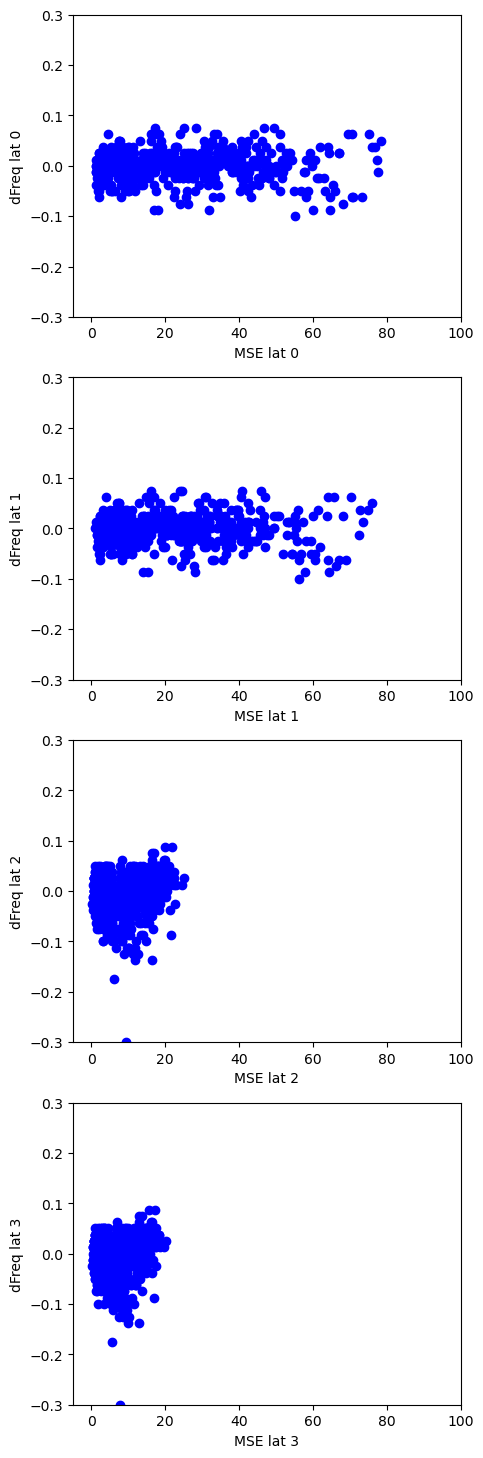

In [799]:
# plot MSE vs. the change in frequency
xLimits = [-5,100];
yLimits = [-0.3,0.3];
plt.figure(figsize=(5,10))
for ii in range(4):

    plt.subplot(4,1,ii+1)
    plt.plot(MSE[:,ii],dFreq[:,ii],'bo');
    plt.xlabel('MSE lat ' + str(ii));
    plt.ylabel('dFreq lat ' + str(ii));
    plt.xlim(xLimits);
    plt.ylim(yLimits);
    plt.subplots_adjust(top=1.5);

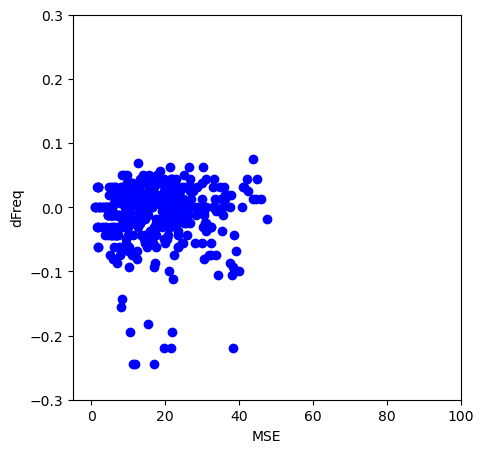

In [800]:
# calculate a mean change in frequency and a mean error across dimensions
mean_dFreq = np.mean(dFreq,axis=1)
mean_MSE   = np.mean(MSE,axis=1);

# plot
xLimits = [-5,100];
yLimits = [-0.3,0.3];
plt.figure(figsize=(5,5));
plt.plot(mean_MSE,mean_dFreq,'bo');
plt.xlabel('MSE');
plt.ylabel('dFreq');
plt.xlim(xLimits);
plt.ylim(yLimits);

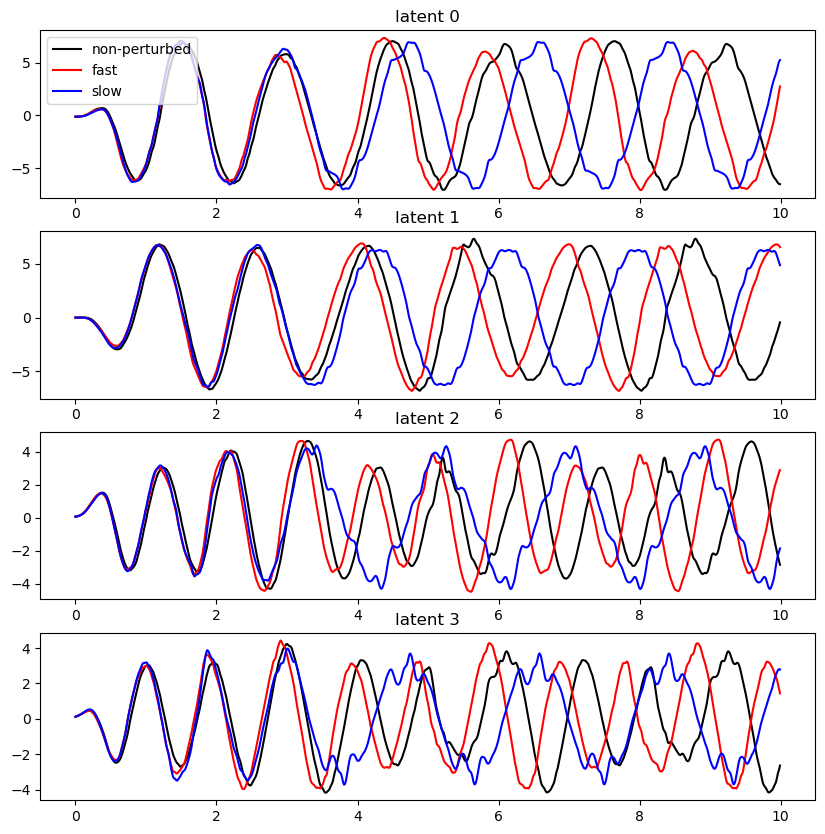

In [805]:
# pull out the perturbations that led to the largest and smallest changes
# limit ourselves to changes that didn't have a large error
fastIdx = np.nonzero((mean_dFreq > 0.05) & (mean_MSE < 20))[0][0]
slowIdx = np.nonzero((mean_dFreq < -0.2) & (mean_MSE < 12))[0][0]

U_fast  = U_pert_all[:,:,fastIdx]
U_slow  = U_pert_all[:,:,slowIdx]

# generate the outputs for these perturbations
output_fast = runWithUPert(U_fast)
output_slow = runWithUPert(U_slow)

# plot all of the latents
plt.figure(figsize=(10,10))

# how much of the output to plot
plotL = 1000
t = np.arange(0,plotL) * dt
for ii in range(numZ):
    plt.subplot(numZ,1,ii+1);
    plt.plot(t,Z_noPerturb[:plotL,ii],linewidth=1.5,color='k',label='non-perturbed')
    plt.plot(t,output_fast[:plotL,ii],linewidth=1.5,color='r',label='fast')
    plt.plot(t,output_slow[:plotL,ii],linewidth=1.5,color='b',label='slow')
    if ii==0:
        plt.legend();
    plt.title('latent ' + str(ii))

In [792]:
out = output_slow[:,0]
baseline = Z_noPerturb[:,0]

# calculate main frequency
out_freq = returnPeakFreq(out, dt)
bsline_freq = returnPeakFreq(baseline, dt)

signal1 = out
signal2 = baseline

freq1 = out_freq
freq2 = bsline_freq

# duration of original signal
oSignalDur = signal1.size

# figure out which signal needs to be stretched
if freq1 < freq2:
    slowSignal = signal1
    fastSignal = signal2
    slowFreq = freq1
    fastFreq = freq2
    stretchFlag = True
elif freq2 < freq1:
    slowSignal = signal2
    fastSignal = signal1
    slowFreq = freq2
    fastFreq = freq1
    stretchFlag = True
else:
    # if both signals have the same dominant frequency, no need to do any stretching
    slowSignal = signal1
    fastSignal = signal2
    stretchFlag = False

if stretchFlag:

    # calculate the ratio of the fast signal to the slow signal
    freqRatio = fastFreq/slowFreq

    # generate a stretched time base for the faster signal
    fastTimes_stretched = np.arange(0,oSignalDur) * freqRatio

    # interpolate the faster signal to get a signal the same length as the slow signal
    fastSignal = np.interp(np.arange(0,oSignalDur),fastTimes_stretched,fastSignal)




### It looks like adding J_0 actually might make perturbations to U more effective.
    - test this by generating a few different networks with different J_0 strengths, and applying the same perturbations


In [892]:
# keep all parameters the same, except for the std of the distribution we use to draw J_0

# initialize the constant parameters for all of the networks

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
numZ = 4

## draw our U and J0 weights ##

# U first
U = np.random.uniform(low=uMin,high=uMax, size=(numZ,numN)) * g_U

## define our target latents, Z ##
Z_target = proj[:,:numZ]

## number of trials to train ##
numTrials = 10

## trial duration ##
# use different durations for training and testing
trlDur_train = 500
trlDur_test = 8000

## initialize W ##
W0 = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ))

## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))

## initial latents, z0 ##
z0 = np.zeros((numZ,1))

## initial value of P ##
P0 = np.eye(numN) / alpha

# define our U_perturbs

# number of different perturbations
numPerts = 500

# perturbation magnitude
pertMag = 0.01

# save each U_pert
uPert_all = np.random.normal(loc=0,scale=pertMag,size = (U.shape[0],U.shape[1],numPerts))

In [893]:
# define the different gains for J_0
g_j0 = [0,0.001,0.01,0.1,1]

# number of networks
numNetworks = len(g_j0)

# define our J0's
J0_all = np.zeros((numN,numN,numNetworks))
for ii in range(numNetworks):
    J0_all[:,:,ii] = np.random.normal(loc=0, scale=(g_j0[ii]**2)/(numN * tau**2), size=(numN,numN))

In [894]:
# define a function that uses FORCE to train a network
def trainWithForce(j0):


    # initialize an array to hold output
    out = np.zeros((trlDur_train,numZ,numTrials))

    # initialize p and w
    p = np.copy(P0)
    w = np.copy(W0)

    for trl in range(numTrials):

        # set the initial state, rate, and latent
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through the trial
        for ii in range(trlDur_train):

            # update our state
            x += (1/tau) * (-x + (j0.T@r) + (U.T@z))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = w.T@r

            # save the output
            out[ii,:,trl] = z[:,0]

            # calculate the error
            error = np.atleast_2d(z[:,0] - Z_target[ii,:])

            # update the weights
            w = w - ((p @ r)@error)

            # update P
            p = p - ((p @ r @ r.T @ p)/(1 + (r.T @ p @ r)))

    # return output and the W weights
    return out, w

In [1198]:
# function for returning rates of network
def runForward(u,j0,w,tDur):

    # run the network forward

    # keep track of output
    out = np.zeros((tDur,numZ))

    # set the inital states/rates/Z
    x = np.copy(x0)
    r = np.copy(r0)
    z = np.copy(z0)

    # cycle through time
    for ii in range(tDur):

        # update our state
        x += (1/tau) * (-x + (j0.T@r) + (u.T@z))

        # calculate our current rate
        r = np.tanh(x)

        # calculate the current z
        z = w.T@r

        # save the output
        out[ii,:] = z[:,0]

    # return output
    return out

In [1040]:
# function for getting the output (through B) from a trained network

def returnOutput(u,j0,w,b):

    # keep track of output
    modelOutput = np.zeros(trlDur_train)

    # set the inital states/rates/Z
    x = np.copy(x0)
    r = np.copy(r0)
    z = np.copy(z0)

    # cycle through time
    for ii in range(trlDur_train):

        # update our state
        x += (1/tau) * (-x + (j0.T@r) + (u.T@z))

        # calculate our current rate
        r = np.tanh(x)

        # calculate the current z
        z = w.T@r

        # calculate output
        modelOutput[ii] = r.T @ b

    # return output
    return modelOutput

In [1120]:
# function for getting the rates from a trained network
def returnRates(u,j0,w):

    # keep track of rates
    allRates = np.zeros((trlDur_test,numN))

    # set the inital states/rates/Z
    x = np.copy(x0)
    r = np.copy(r0)
    z = np.copy(z0)

    # cycle through time
    for ii in range(trlDur_test):

        # update our state
        x += (1/tau) * (-x + (j0.T@r) + (u.T@z))

        # calculate our current rate
        r = np.tanh(x)

        # calculate the current z
        z = w.T@r

        # save the rates
        allRates[ii,:] = r[:,0]

    # return output
    return allRates

In [896]:
# function for calculating dFreq and MSE of a bunch of perturbations
def calcFreq_MSE_pert(u,j0,w,z_nopert,u_perts):

    # initialize an array to hold change in frequencies (numPerts x numZ)
    d_freq = np.zeros((numPerts,numZ)) + np.nan

    # MSE for each perturbation and each Z
    mse = np.zeros((numPerts,numZ)) + np.nan

    # save a bit of time by calculating the dominant frequency for each of the unperturbed Z's
    o_freq = np.zeros(numZ) + np.nan
    for ii in range(numZ):
        o_freq[ii] = returnPeakFreq(z_nopert[:,ii], dt)

    # cycle through perturbations
    for ii in range(numPerts):

        # get the output for this perturbation
        out = runForward(u + u_perts[:,:,ii],j0,w)

        # for each dimension, calculate change in frequency and adjusted MSE
        for jj in range(numZ):

            # pull out our original output and perturbed output for this dimension
            output_noPerturb = z_nopert[:,jj]
            output_perturb = out[:,jj]

            # calculate the dominant frequency in the perturbed Z
            perturbFreq = returnPeakFreq(output_perturb, dt)

            # save the change in the frequency
            d_freq[ii,jj] = perturbFreq - o_freq[jj]

            # calculate the adjusted MSE
            mse[ii,jj] = calculateAdjustedMSE(output_perturb, output_noPerturb, perturbFreq, o_freq[jj])


    # return outputs
    return mse,d_freq

In [897]:
## initialize arrays to hold MSE and dFreq data
MSE = np.zeros((numPerts,numZ,numNetworks)) + np.nan
dFreq = np.zeros((numPerts,numZ,numNetworks)) + np.nan

## cycle through networks
for nn in range(numNetworks):

    # train the original network
    J0 = J0_all[:,:,nn]
    networkOut_training,W = trainWithForce(J0)

    # get the unperturbed output
    unperturbedZ = runForward(U,J0,W)

    # run the perturbation experiment
    MSE[:,:,nn],dFreq[:,:,nn] = calcFreq_MSE_pert(U,J0,W,unperturbedZ,uPert_all)

In [898]:
# save the results and the J0's

# directory for the data
saveDir = '/Users/andrew/Documents/Projects/Churchland/BG/networks/uPert/data/j0_experiment/'

# put everything in a dictionary
d1 = {'J0_all': J0_all, 'MSE': MSE, 'dFreq':dFreq,'j0_gains':g_j0}

# get current time
ct = str(datetime.datetime.now())[:19]

# replace colons with an underscore
ct = ct.replace(':','_')

# save
np.save(saveDir + 'j0_experiment_results_' + ct + '.npy',d1)


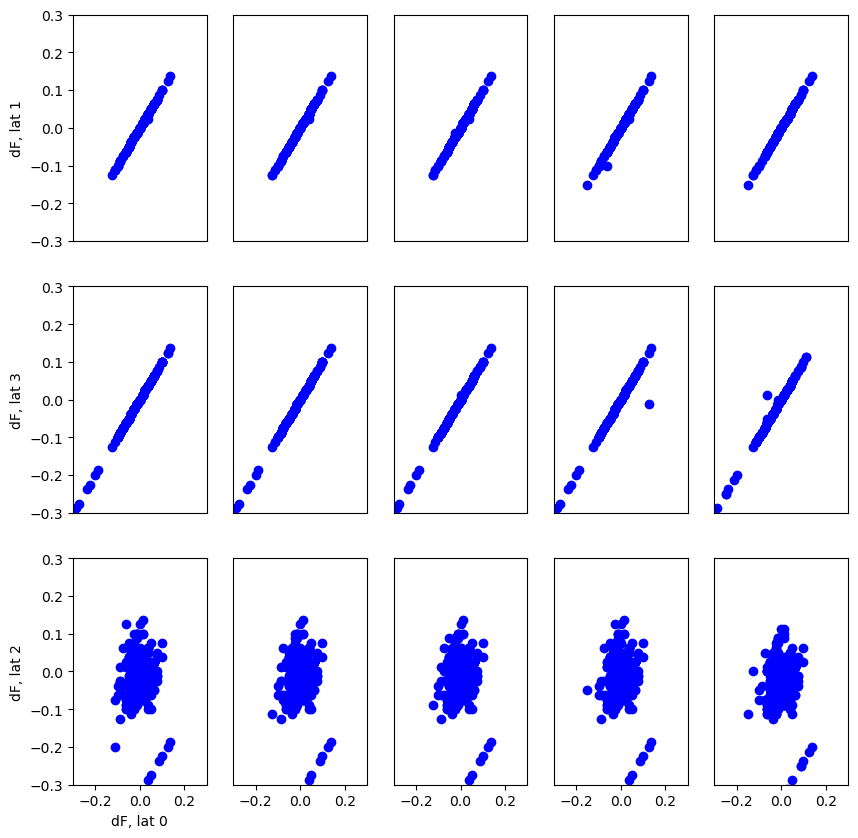

In [902]:
# plot change in frequency for each latent, for each network

# plot the changes in frequency
limits = [-0.3,0.3]

# rows -> latents
# columns -> networks
fig,ax = plt.subplots(3,numNetworks,figsize=(10,10))

# cycle through networks
for nn in range(numNetworks):

    ax[0,nn].plot(dFreq[:,0,nn],dFreq[:,1,nn],'bo');
    ax[0,nn].set_xlim(limits);
    ax[0,nn].set_ylim(limits);
    if nn == 0:
        ax[0,nn].set_xlabel('dF, lat 0')
        ax[0,nn].set_ylabel('dF, lat 1')
    ax[0,nn].xaxis.set_visible(False)
    if nn > 0:
        ax[0,nn].yaxis.set_visible(False)

    ax[1,nn].plot(dFreq[:,2,nn],dFreq[:,3,nn],'bo');
    ax[1,nn].set_xlim(limits);
    ax[1,nn].set_ylim(limits);
    if nn == 0:
        ax[1,nn].set_xlabel('dF, lat 2')
        ax[1,nn].set_ylabel('dF, lat 3')
    ax[1,nn].xaxis.set_visible(False)
    if nn > 0:
        ax[1,nn].yaxis.set_visible(False)

    ax[2,nn].plot(dFreq[:,0,nn],dFreq[:,2,nn],'bo');
    ax[2,nn].set_xlim(limits);
    ax[2,nn].set_ylim(limits);
    if nn == 0:
        ax[2,nn].set_xlabel('dF, lat 0')
        ax[2,nn].set_ylabel('dF, lat 2')
    if nn > 0:
        ax[2,nn].yaxis.set_visible(False)


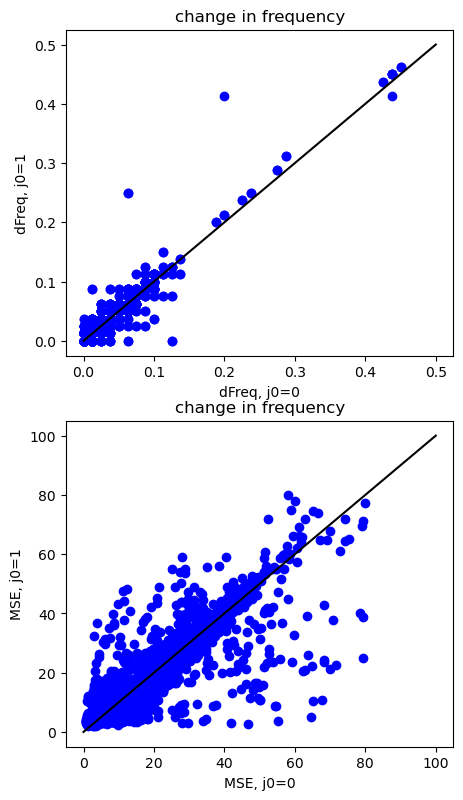

In [934]:
# directly compare the effects of the same perturbations on different networks

plt.figure(figsize=(5,3));
plt.subplot(2,1,1);
plt.plot(np.abs(dFreq[:,:,0].reshape(-1,1)[:,0]),np.abs(dFreq[:,:,-1].reshape(-1,1)[:,0]),'bo');
plt.plot([0,0.5],[0,0.5],'k');
plt.xlabel('dFreq, j0=0');
plt.ylabel('dFreq, j0=1');
plt.title('change in frequency');

plt.subplot(2,1,2);
plt.plot(np.abs(MSE[:,:,0].reshape(-1,1)[:,0]),np.abs(MSE[:,:,-1].reshape(-1,1)[:,0]),'bo');
plt.plot([0,100],[0,100],'k');
plt.xlabel('MSE, j0=0');
plt.ylabel('MSE, j0=1');
plt.title('change in frequency');
plt.subplots_adjust(top=2.5);

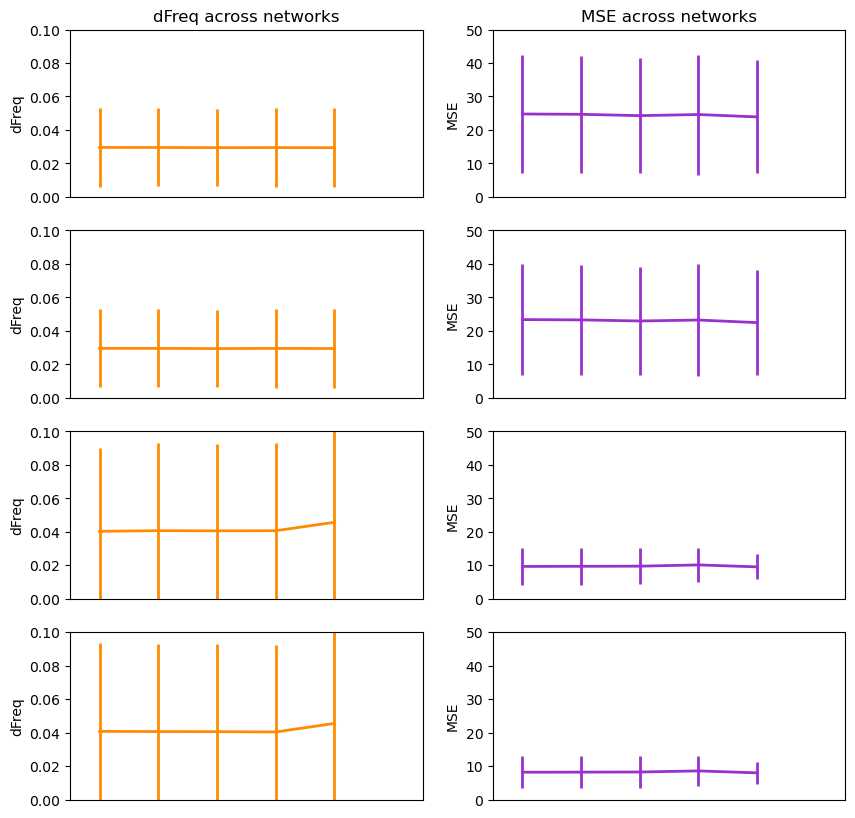

In [941]:
# I'm not sure whether the above is a fair comparison. We're learning different W's, so comparing the effects of 'the same' perturbations may be difficult.
# we can compare averages though.

# for each network (and each latent, calculate the mean change in frequency and the mean error)
MSE_mean = np.mean(MSE,axis=0)
MSE_std  = np.std(MSE,axis=0)

dFreq_mean = np.mean(np.abs(dFreq),axis=0)
dFreq_std  = np.std(np.abs(dFreq),axis=0)

# initialize a figure
# rows -> latents
# columns -> dFreq and MSE
fig,ax = plt.subplots(numZ,2,figsize=(10,10))

# define some colors
freqColor = 'darkorange'
mseColor  = 'darkorchid'

# define some plotting limits
xLimit = [-0.5,5.5]
yLimit_freq = [0,0.1]
yLimit_mse = [0,50]
# cycle through latents
for ii in range(numZ):

    # plot mean (absolute) dFreq

    ax[ii,0].errorbar(np.arange(numNetworks),dFreq_mean[ii,:],yerr=dFreq_std[ii,:],color=freqColor,linewidth=2);
    ax[ii,0].set_xlim(xLimit);
    ax[ii,0].set_ylim(yLimit_freq);
    ax[ii,0].set_ylabel('dFreq')
    ax[ii,0].xaxis.set_visible(False)
    if ii == 0:
        ax[ii,0].set_title('dFreq across networks')

    # plot average MSE
    ax[ii,1].errorbar(np.arange(numNetworks),MSE_mean[ii,:],yerr=MSE_std[ii,:],color=mseColor,linewidth=2);
    ax[ii,1].set_xlim(xLimit);
    ax[ii,1].set_ylim(yLimit_mse);
    ax[ii,1].set_ylabel('MSE')
    ax[ii,1].xaxis.set_visible(False)
    if ii == 0:
        ax[ii,1].set_title('MSE across networks')




### Explore 'readout perturbations'
    - everything above could be considered alteration to the network dynamics.
    - altering the frequency of the latents requires the effective dynamics to change.
    - if we had a readout unit, the frequency of the output could presumably be reliably changed.

    - Let's add in an explicit readout now, B.
    - B will allow us to read out a sine from the activity of the network units.
    - Let's choose a dU that brings (dU + U) into closer alignment with B. This will have large effects on the output, if B and U are mostly orthogonal to begin with.
    - Because B and W are basically orthogonal, and U and W are orthogonalish, dU should have almost no effect on the latents.

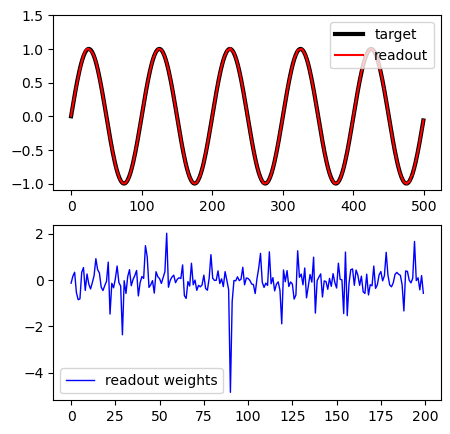

In [1139]:
## use regression to define a B ##
# choose B such that it is in the null space of W

# get the unperturbed rates from our network
rates = returnRates(U,J0,W)

# for now, only keep the rates from the times that were trained with FORCE
rates = rates[:500,:]
rL,numN = rates.shape

# define the sine that we want to read out
freq = 1
t = np.arange(0,rL)*dt
s1 = np.sin(freq * 2 * np.pi * t)

# define a regularization term
ridgeLambda = 0.0

# define the null space of W, project rates into this space
W_null = scipy.linalg.null_space(W.T)
rates_null = rates@W_null

# regress
b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ s1
B = W_null@b_null

# plot target and target_hat
yHat = rates @ B
plt.figure(figsize=(5,5))
plt.subplot(2,1,1);
plt.plot(s1,'k',linewidth=3,label='target');
plt.plot(yHat,'r',label='readout');
plt.ylim([-1.1,1.5]);
plt.legend();

# plot B
plt.subplot(2,1,2);
plt.plot(B,'b',linewidth=1,label='readout weights');
plt.legend();



In [1140]:
# measure correlation between U and B
for ii in range(numZ):
    tempCorr = np.corrcoef(B,U.T[:,ii])[0,1]
    print('B and U dim. ' + str(ii) + ' rho: ' + str(tempCorr))

print('')
# do the same for W and B
for ii in range(numZ):
    tempCorr = np.corrcoef(B,W[:,ii])[0,1]
    print('B and W dim. ' + str(ii) + ' rho: ' + str(tempCorr))

B and U dim. 0 rho: -0.02335358689940274
B and U dim. 1 rho: -0.010856748202332168
B and U dim. 2 rho: 0.0010221732193546097
B and U dim. 3 rho: 0.048227689776105254

B and W dim. 0 rho: -0.0028829405470572247
B and W dim. 1 rho: -0.003986424916131362
B and W dim. 2 rho: 0.009909587666125593
B and W dim. 3 rho: 0.014730945558962026


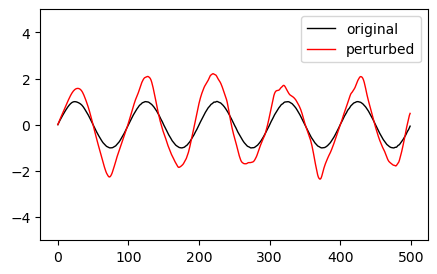

In [1190]:
# as an experiment, take a small fraction of B and add it to U.

# get the unperturbed (original) output
output_o = returnOutput(U,J0,W,B)

# fraction of B to add to U
bFract = np.array((0.000,0.000,0.008,0.008))
bFract = bFract[:,np.newaxis]

# generate U_perturb
U_perturb = U + (B * bFract)

# generate a perturbed output
output_p = returnOutput(U_perturb,J0,W,B)

# plot original and perturbed output
plt.figure(figsize = (5,3))
plt.plot(output_o,'k',linewidth=1,label='original');
plt.plot(output_p,'r',linewidth=1,label='perturbed');
plt.ylim([-5,5]);
plt.legend();

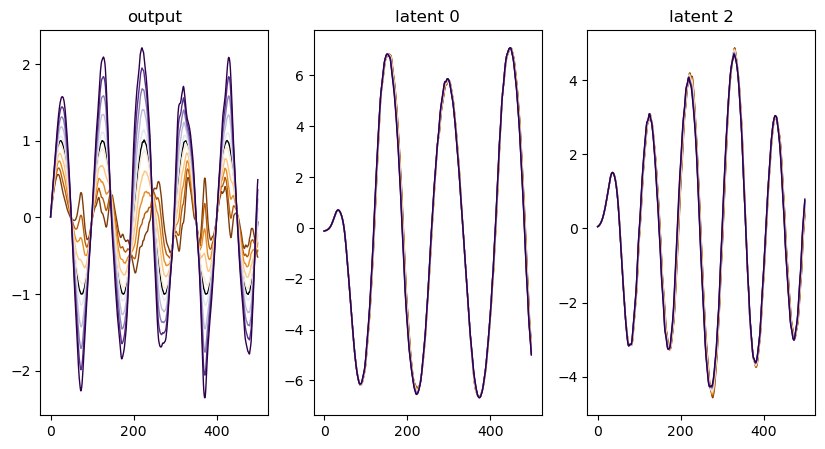

In [1221]:
# because our latents are more complicated that just a sine and a cosine, there isn't going to be a straighforward relationship between dU and the difference in the output.
# All we need is that the changes are smooth; similar dU's lead to similar changes in the output.
# We also want to see that changes to dU have minimal impact on the latents themselves.

# manually choose perturbations and show that they have interpretable effects
numPerts = 10
perts = np.linspace(start=-0.008,stop=0.008,num = numPerts)

# array for our outputs
pertOutput = np.zeros((trlDur_train,numPerts))

# array for latents
pertZ      = np.zeros((trlDur_train,numZ,numPerts))

# get the (original) unperturbed latents
Z_o = runForward(U,J0,W,trlDur_train)


# cycle through perturbations
for ii in range(numPerts):

    # generate the perturbation

    bFract = np.array((0.000,0.000,perts[ii],perts[ii]))
    bFract = bFract[:,np.newaxis]

    # generate U_perturb
    U_perturb = U + (B * bFract)

    # generate a perturbed output
    pertOutput[:,ii] = returnOutput(U_perturb,J0,W,B)

    # generate Zs
    pertZ[:,:,ii] = runForward(U_perturb,J0,W,trlDur_train)

# plot the unperturbed output
plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.title('output')
plt.plot(output_o,'k',linewidth=1,label='original');

plt.subplot(1,3,2);
plt.title('latent 0')
plt.plot(Z_o[:,0],'k',linewidth=1,label='original');

plt.subplot(1,3,3);
plt.title('latent 2')
plt.plot(Z_o[:,2],'k',linewidth=1,label='original');

# choose a colormap for the plots
import matplotlib
cmap = matplotlib.colormaps['PuOr']
colors = cmap(np.linspace(0,1,numPerts))

# plot perturbations
plt.subplot(1,3,1)
for ii in range(numPerts):
    plt.plot(pertOutput[:,ii],linewidth=1,color=colors[ii,:])

plt.subplot(1,3,2)
for ii in range(numPerts):
    plt.plot(pertZ[:,0,ii],linewidth=1,color=colors[ii,:])

plt.subplot(1,3,3)
for ii in range(numPerts):
    plt.plot(pertZ[:,2,ii],linewidth=1,color=colors[ii,:])



In [1561]:
# estimate the gradient at every time step

# number of trials
numTrials = 20

# generate a target
amp2 = 2
target2 = np.sin(freq * 2 * np.pi * t) * amp2

# generate the original output
out = output_o

# initialize the U (keep it separate from our original U
U_learn = np.copy(U)

# generate our current error
current_e = ((out - target2)**2).mean()

# get current learning rate
alpha = 1

# the size of the perturbation at each step
pertMag = 7e-5

# initialize an array to hold all of our outputs
output_learn = np.zeros((trlDur_train,numTrials)) + np.nan

# keep track of our error
allError = np.zeros(numTrials)

# keep track of total perturbation
totPert = np.zeros(4)

# save all of our Us
allUs = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

# save all of the perturbations
allPerts = np.zeros((4,numTrials))

# cycle through trials
for ii in range(numTrials):

    # save current U
    allUs[:,:,ii] = U_learn

    # our 4 perturbations are always the same
    pert_all = np.zeros((4,4))
    for jj in range(4):
        pert_all[jj,jj] = pertMag


    # generate U_perturb
    U_p = np.zeros((U_learn.shape[0],U_learn.shape[1],4))
    for jj in range(4):
        tempPert = pert_all[:,jj]
        tempPert = tempPert[:,np.newaxis]
        U_p[:,:,jj] = U_learn + (B * tempPert)

    # generate a perturbed output
    out_all = np.zeros((trlDur_train,4))
    for jj in range(4):
        out_all[:,jj] = returnOutput(U_p[:,:,jj],J0,W,B)

    # calculate new error
    e_all = np.zeros(4)
    for jj in range(4):
        e_all[jj] = ((out_all[:,jj] - target2)**2).mean()

    # calculate the change in error
    dE = current_e - e_all

    # calculate the step
    step = dE * alpha


    # take a step in the direction as dictated by the change in error from the perturbations
    pert = np.copy(step)
    totPert += pert
    pert = pert[:,np.newaxis]

    # save all of the perturbations
    allPerts[:,ii] = pert[:,0]

    # add the perturbation to U
    U_learn += (B * pert)

    # calculate the new error
    out = returnOutput(U_learn,J0,W,B)
    current_e = ((out - target2)**2).mean()

    # save error
    allError[ii] = current_e

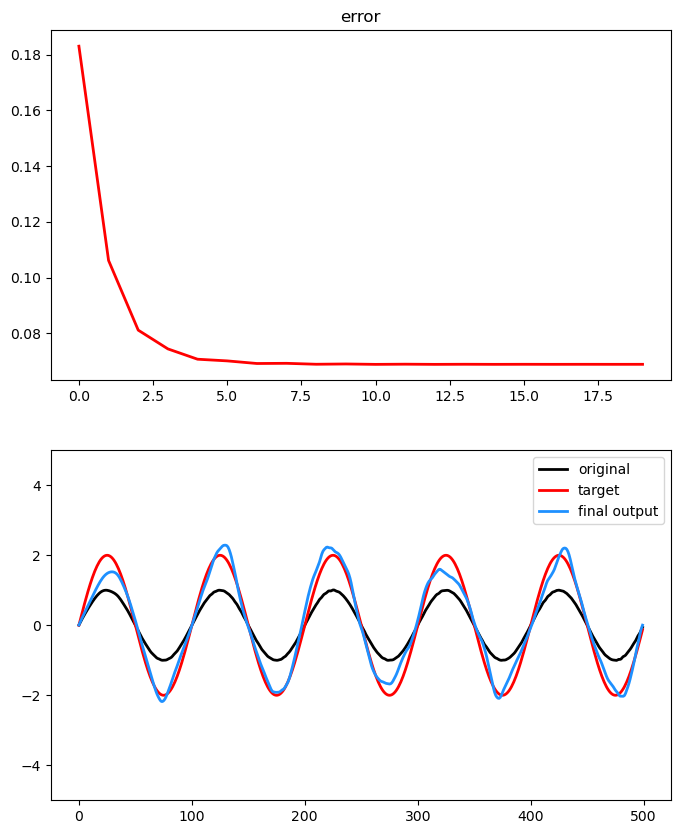

In [1562]:
# regenerate the output with the current U
out_final = returnOutput(U_learn,J0,W,B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(allError,'r',linewidth=2)
plt.title('error')


# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(output_o,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-5,5]);
plt.legend();